In [1]:
import cv2 as cv
import matplotlib.pyplot as plt
import pickle
import numpy as np

from tensorflow.keras import regularizers
import tensorflow as tf
import tensorflow_docs.plots
from tensorflow.keras.optimizers import Adam
from keras_tuner import RandomSearch
from keras_tuner.applications import HyperResNet

from sklearn.model_selection import train_test_split
import imgaug.augmenters as iaa


In [2]:
with(open('resources/train_images/dados_2021_08_31_20_12_13.606412_315_imagens','rb')) as openfile:
    dados_brutos = pickle.load(openfile)

In [3]:
with(open('resources/train_images/dados_2021_08_31_20_29_55.928042_298_imagens','rb')) as openfile:
    tuplas_2 = pickle.load(openfile)

In [4]:
for tupla in tuplas_2:
    dados_brutos.append(tupla)

In [5]:
len(dados_brutos)

613

In [6]:
dados_brutos[0][0].shape

(120, 160, 3)

In [7]:
dados_brutos[100][1].replace('LEFT','RIGHT').replace('RIGHT','LEFT')

'LEFT MAX'

## Aumentando os dados com o flip horizontal

In [8]:
for idx in range(len(dados_brutos)):
    if 'LEFT' in dados_brutos[idx][1] or 'RIGHT' in dados_brutos[idx][1]:
        flip = cv.flip(dados_brutos[idx][0],1)
        if 'LEFT' in dados_brutos[idx][1]:
            direction = dados_brutos[idx][1].replace('LEFT','RIGHT')
        else:
            direction = dados_brutos[idx][1].replace('RIGHT','LEFT')
        dados_brutos.append((flip,direction))  

In [9]:
len(dados_brutos)

1046

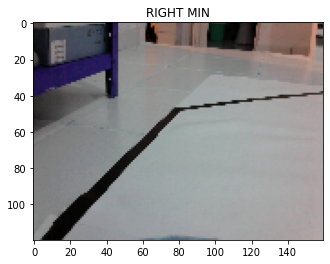

In [10]:
plt.imshow(dados_brutos[900][0])
plt.title(dados_brutos[900][1])
plt.show()

## Aumentando os dados com ZOOM

In [11]:
qnt_img = len(dados_brutos)
for i in range(qnt_img):
    zoom = iaa.Affine(scale=(1,1.3))
    img_zoom = zoom.augment_image(dados_brutos[i][0])
    dados_brutos.append((img_zoom,dados_brutos[i][1]))
len(dados_brutos)

2092

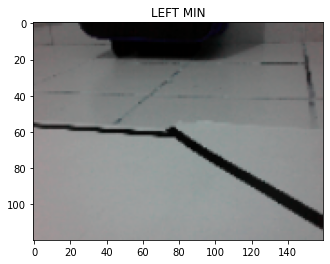

In [12]:
plt.imshow(dados_brutos[1500][0])
plt.title(dados_brutos[1500][1])
plt.show()

## Aumentando os dados com SUPERPIXEL

In [13]:
qnt_img = len(dados_brutos)
for i in range(qnt_img):
    super_pixel = iaa.Superpixels(p_replace=(0.1, 1.0), n_segments=(16, 128))
    img_px = super_pixel.augment_image(dados_brutos[i][0])
    dados_brutos.append((img_px,dados_brutos[i][1]))
len(dados_brutos)

/home/lacouth/anaconda3/envs/cv/lib/python3.9/site-packages/imgaug/augmenters/segmentation.py:271: FutureWarning: skimage.measure.label's indexing starts from 0. In future version it will start from 1. To disable this warning, explicitely set the `start_label` parameter to 1.
  segments = skimage.segmentation.slic(


4184

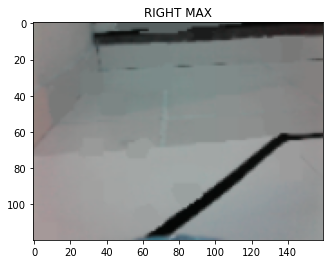

In [14]:
plt.imshow(dados_brutos[2200][0])
plt.title(dados_brutos[2200][1])
plt.show()

## Separando as imagens dos labels e convertendo as imagens para tons de cinza

In [15]:
input_img = [cv.cvtColor(tupla[0],cv.COLOR_RGB2GRAY) for tupla in dados_brutos]

In [16]:
labels = np.array([tupla[1] for tupla in dados_brutos])

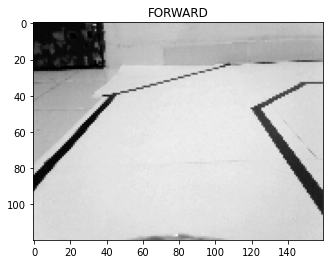

In [17]:
plt.imshow(input_img[0],cmap='gray')
plt.title(labels[0])
plt.show()

## Tratando as labels

In [18]:
label_dict = {'LEFT MIN':0,'LEFT MAX':1,'FORWARD':2, 'RIGHT MIN':3, 'RIGHT MAX':4}
label_encoded = np.array([label_dict[direction] for direction in labels])

## Dividindo os conjuntos de treino e teste

In [19]:
X_train, X_test, y_train, y_test = train_test_split(input_img, label_encoded, test_size=0.1, random_state=42)

In [20]:
X_train = np.array(X_train) / 255.0
X_test = np.array(X_test) / 255.0

In [21]:
X_train = X_train[..., tf.newaxis]
X_test = X_test[..., tf.newaxis]

In [22]:
y_test_hot = tf.one_hot(y_test,5)
y_train_hot = tf.one_hot(y_train,5)

2021-09-08 20:42:52.397548: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Treinando o modelo - VGG16
https://arxiv.org/pdf/1409.1556.pdf

https://towardsdatascience.com/step-by-step-vgg16-implementation-in-keras-for-beginners-a833c686ae6c

In [23]:
def build_model(hp):
    REG = 0.001
    DROP = 0.25
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Flatten())
    
    
    model.add(tf.keras.layers.Dense(hp.Int("units",min_value=128,max_value=1024,step=128),activation='sigmoid', kernel_regularizer=regularizers.l2(hp.Choice('REG',values=[0.0, 0.001, 0.01,0.1]))))
    model.add(tf.keras.layers.Dropout(hp.Choice('drop',values=[0.0, 0.05, 0.1, 0.25, 0.5])))
    
    model.add(tf.keras.layers.Dense(5, activation='softmax'))

    model.compile(optimizer=Adam(hp.Choice('learning_rate',values=[5e-5,5e-6,1e-5,1e-6])),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model

In [24]:
# hypermodel = HyperResNet(input_shape=(120,160,1), classes=5)

In [25]:
tuner = RandomSearch(
    build_model,
    objective="val_accuracy",
    max_trials=10,
    overwrite=True,
    directory="my_dir",
    project_name="autonomous_rc",
)

In [26]:
tuner.search(X_train, y_train_hot, epochs=1000, validation_split=0.2,callbacks = [tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', min_delta=0, patience=100)])

Trial 10 Complete [01h 39m 07s]
val_accuracy: 0.8472775816917419

Best val_accuracy So Far: 0.8671978712081909
Total elapsed time: 12h 00m 51s
INFO:tensorflow:Oracle triggered exit


In [27]:
tuner.results_summary()

Results summary
Results in my_dir/autonomous_rc
Showing 10 best trials
Objective(name='val_accuracy', direction='max')
Trial summary
Hyperparameters:
units: 768
REG: 0.001
drop: 0.1
learning_rate: 5e-05
Score: 0.8671978712081909
Trial summary
Hyperparameters:
units: 640
REG: 0.001
drop: 0.25
learning_rate: 5e-05
Score: 0.8472775816917419
Trial summary
Hyperparameters:
units: 1024
REG: 0.001
drop: 0.25
learning_rate: 5e-05
Score: 0.824701189994812
Trial summary
Hyperparameters:
units: 256
REG: 0.01
drop: 0.1
learning_rate: 1e-05
Score: 0.6985391974449158
Trial summary
Hyperparameters:
units: 1024
REG: 0.01
drop: 0.05
learning_rate: 5e-06
Score: 0.6945551037788391
Trial summary
Hyperparameters:
units: 256
REG: 0.01
drop: 0.1
learning_rate: 5e-06
Score: 0.6905710697174072
Trial summary
Hyperparameters:
units: 896
REG: 0.01
drop: 0.0
learning_rate: 5e-05
Score: 0.6865869760513306
Trial summary
Hyperparameters:
units: 384
REG: 0.1
drop: 0.1
learning_rate: 5e-05
Score: 0.6401062607765198
Tri

In [28]:
model = tuner.get_best_models(num_models=1)

In [ ]:
# history = model.fit(X_train,
#                     y_train_hot, 
#                     validation_split=0.2, 
#                     batch_size = 100, 
#                     epochs=1000,
#                    callbacks = [tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', min_delta=0, patience=100),
#                                 tf.keras.callbacks.ModelCheckpoint("SMALL_MLP_1.h5", monitor='val_accuracy', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', save_freq='epoch')])

In [29]:
model[0].evaluate(X_test,y_test_hot,verbose=2)

14/14 - 1s - loss: 0.5412 - accuracy: 0.8663


[0.5411815047264099, 0.8663484454154968]

In [34]:
model[0].evaluate(X_train,y_train_hot,verbose=2)

118/118 - 3s - loss: 0.3032 - accuracy: 0.9631


[0.30321359634399414, 0.9630810022354126]

In [35]:
model[0].save('models/MLP_one_86_09_set_2021')

2021-09-09 11:23:31.343931: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: models/MLP_one_86_09_set_2021/assets


In [ ]:
converter = tf.lite.TFLiteConverter.from_saved_model('models/MLP_one_86_09_set_2021/')
tflite_model = converter.convert()
with open('models/mlp_model.tflite', 'wb') as f:
    f.write(tflite_model)

In [30]:
history = model[0].history

In [31]:
training_loss = history.history['loss']
val_loss = history.history['val_loss']

epoch_count = range(1, len(training_loss) + 1)

plt.plot(epoch_count, training_loss, 'r--')
plt.plot(epoch_count, val_loss, 'b-')
plt.legend(['Erro de treinamento', 'Erro de validação'])
plt.xlabel('Época')
plt.ylabel('Erro')
plt.grid()
plt.show()

KeyError: 'loss'

In [33]:
history.history

{}